In [1]:
from numpy.linalg import pinv, norm, solve, lstsq
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
S, R = make_regression(n_samples=10000, n_features=10, n_informative=10, noise=50.0, random_state=1)
S, S_test, R, R_test = train_test_split(S, R)

In [3]:
w = pinv(S) @ R
R_pred = S@w
print(r2_score(R, R_pred))
print(mean_squared_error(R, R_pred))

# w = lstsq(S, R, rcond=-1)[0]
# R_pred = S@w
# print(r2_score(R, R_pred), )
# print(mean_squared_error(R, R_pred))

R_pred = S_test@w
print(r2_score(R_test, R_pred))
print(mean_squared_error(R_test, R_pred))

0.9419189282002026
2452.5725339441606
0.9414922509477622
2591.8139248279726


**Задача**: Проверить, что для решения задачи регрессии выбор данных с помощью максимизации статистичекого объема лучше выбора случайной подвыборки того же размера. 

**Дизайн эксперимента**:  
*В цикле*:  
Из $S$ вытаскивается 4 (количество действий) вектора $\phi(s, a)$.
Далее рассматривается два способа выбора одного из этих векторов для занесения в свою историю $H$ (exploration):  
1. Агент выбирает одно из них согласно $argmax ||H^+ \phi(s,a)||_2$
2. Агент выбирает одно из них случайно
3. (---) Агент выбирает одно из них $\varepsilon$-жадно согласно на данной момент выученной Q-функции

C некоторой частотой обучаем регрессию на собранных разными способами H и сравниваем результаты. Хочется, чтобы у первого способа качество было лучше

In [4]:
R.shape

(7500,)

In [5]:
class Agent:
    def __init__(self, method='random'):
        self.H = None #states
        self.R = [] # rewards for self.H - used for fit
        self.w = None # Q-function weights
        self.method = method
        
#       todo: add fit_flag
        
    def choose_phi(self, Phi, R, method=None, update_H=True):
        if method is None:
            method = self.method
        if self.H is None:
            method = 'random'
            
        if method == 'random':
            ind = np.random.randint(Phi.shape[0], size=1)
        elif method == 'stat_volume':
            H_pinv = pinv(self.H)
#             print([norm(H_pinv.T@phi) for phi in Phi])
            ind = np.argmax([norm(H_pinv.T@phi) for phi in Phi])
            
        phi = Phi[ind]
        r = R[ind]
            
        if update_H:
            self.update_H(phi)
            self.R += [r]
        return phi, r
    
    def update_H(self, phi):
        if self.H is None:
            self.H = phi
        else:
            self.H = np.vstack([self.H, phi])
    def fit(self):
        self.w = pinv(self.H) @ self.R
    def predict(self, S):
        return S@self.w
    def evaluate(self, S=S_test, R=R_test):
        R_pred = self.predict(S)
        r2 = r2_score(R, R_pred)
        mse = mean_squared_error(R, R_pred)
#         print('r2_score', r2)
#         print('mse', mse)
        return r2, mse
        

In [16]:
from tqdm import tqdm_notebook

scores = pd.DataFrame()


for n_iter in tqdm_notebook(range(1000)):
    smart_agent = Agent('stat_volume')
    random_agent = Agent('random')

    agents = {'random': random_agent,
                'smart': smart_agent,
             }

    for i in range(500):
        ind = np.random.randint(S.shape[0], size=4)
        for agent_name, agent in agents.items():
    #         print(i, agent_name)
            phi, r = agent.choose_phi(S[ind], R[ind])
            if (i >= 10 and i%10 == 0) or i in [1, 2, 5]:
                agent.fit()
                r2, mse = agent.evaluate(S_test, R_test)
                scores.at[i, agent_name+f'_{n_iter}'] = r2

# fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
# for agent_name in agents:
#     ax[0].plot(scores[agent_name], label=agent_name)
# ax[0].set_title('R2 score')
# ax[0].legend()

# ax[1].plot(scores['random'] / scores['smart'], label = 'random / smart')    
# ax[1].plot(scores*0 + 1)   
# # ax[0].title('R2 score')
# ax[1].legend()
# plt.show()

In [17]:
scores

,random_0,smart_0,random_1,smart_1,random_2,smart_2,random_3,smart_3,random_4,smart_4,...,random_995,smart_995,random_996,smart_996,random_997,smart_997,random_998,smart_998,random_999,smart_999
1,0.218326,0.027577,0.176718,0.527511,0.401783,0.280161,0.029118,0.184468,0.064212,0.095221,...,0.034921,0.256346,0.108604,0.254958,0.095418,0.019972,0.163496,0.194181,0.578690,0.636505
2,0.569475,0.099508,0.405391,0.512921,0.404985,0.550257,0.064843,0.318021,0.330979,0.093060,...,0.146059,0.267504,0.148873,0.390331,0.223887,0.040055,0.273616,0.233916,0.574690,0.651484
5,0.709958,0.486908,0.587337,0.191743,0.793391,0.614825,0.125661,0.332144,0.702692,0.244540,...,0.178372,0.310235,0.562756,0.411665,0.592310,0.489825,0.391905,0.596398,0.579061,0.651248
10,0.368666,0.726680,0.447487,-0.077755,-0.123839,0.552193,0.523796,0.840403,0.746524,0.502301,...,-0.956333,0.540366,0.041199,0.886104,0.349881,0.230516,0.110823,0.740452,0.470596,0.613384
20,0.922241,0.867313,0.908174,0.930042,0.891849,0.921958,0.864174,0.926581,0.875825,0.926770,...,0.924015,0.884226,0.890633,0.921444,0.865304,0.908461,0.921247,0.924086,0.851763,0.924990
30,0.916286,0.911847,0.927377,0.936323,0.917003,0.937966,0.883310,0.920667,0.885304,0.924855,...,0.923948,0.911134,0.919732,0.917784,0.885942,0.925496,0.924775,0.928502,0.901964,0.935385
40,0.922407,0.924725,0.931452,0.935480,0.912469,0.936679,0.904572,0.928078,0.908322,0.929353,...,0.921591,0.930610,0.927319,0.922559,0.894942,0.928229,0.922891,0.934597,0.925397,0.935800
50,0.932875,0.931968,0.930126,0.937663,0.929104,0.936986,0.924715,0.936839,0.920974,0.930099,...,0.929144,0.935819,0.929942,0.929616,0.920311,0.932260,0.929890,0.934148,0.934145,0.936742
60,0.936913,0.931525,0.931962,0.939614,0.932585,0.937601,0.926213,0.937071,0.927126,0.935647,...,0.928655,0.935423,0.931576,0.932164,0.922359,0.933523,0.929433,0.935212,0.937010,0.933668
70,0.936490,0.932146,0.930743,0.938514,0.932819,0.939437,0.928715,0.937109,0.932355,0.936650,...,0.930410,0.934764,0.934550,0.935542,0.929167,0.933781,0.931981,0.936690,0.938253,0.936326


In [21]:
for agent in agents:
    agent_cols = [x for x in scores.columns if agent in x]
    scores[agent + '_mean'] = scores[agent_cols].mean(axis=1)
    scores[agent + '_std'] = scores[agent_cols].std(axis=1)

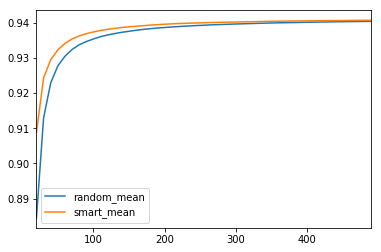

In [32]:
scores[4:][[agent + '_mean' for agent in agents]].plot()

In [34]:
scores['smart_mean']-scores['random_mean']

1     -0.014687
2     -0.015631
5     -0.088500
10     2.001108
20     0.024269
30     0.011378
40     0.006594
50     0.004538
60     0.003664
70     0.002988
80     0.002494
90     0.002238
100    0.001989
110    0.001752
120    0.001614
130    0.001463
140    0.001370
150    0.001260
160    0.001138
170    0.001048
180    0.001012
190    0.000970
200    0.000932
210    0.000894
220    0.000854
230    0.000796
240    0.000758
250    0.000720
260    0.000686
270    0.000655
280    0.000624
290    0.000592
300    0.000568
310    0.000542
320    0.000520
330    0.000501
340    0.000483
350    0.000467
360    0.000456
370    0.000447
380    0.000449
390    0.000429
400    0.000419
410    0.000396
420    0.000380
430    0.000372
440    0.000351
450    0.000342
460    0.000334
470    0.000329
480    0.000324
490    0.000314
dtype: float64

In [33]:
scores['random_std'], 

1       0.163440
2       0.180649
5       0.244540
10     19.198853
20      0.041764
30      0.016615
40      0.010343
50      0.006930
60      0.005743
70      0.004599
80      0.003963
90      0.003593
100     0.003085
110     0.002744
120     0.002482
130     0.002285
140     0.002141
150     0.001950
160     0.001770
170     0.001633
180     0.001525
190     0.001442
200     0.001379
210     0.001318
220     0.001254
230     0.001191
240     0.001153
250     0.001108
260     0.001063
270     0.001025
280     0.000996
290     0.000966
300     0.000944
310     0.000907
320     0.000884
330     0.000851
340     0.000825
350     0.000795
360     0.000768
370     0.000758
380     0.000743
390     0.000724
400     0.000716
410     0.000698
420     0.000678
430     0.000664
440     0.000646
450     0.000637
460     0.000625
470     0.000619
480     0.000610
490     0.000594
Name: random_std, dtype: float64

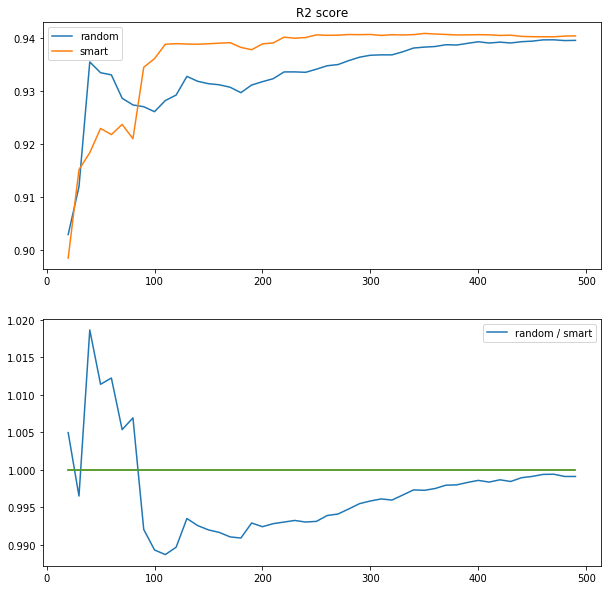

In [7]:
smart_agent = Agent('stat_volume')
random_agent = Agent('random')

agents = {'random': random_agent,
            'smart': smart_agent,
         }

scores = pd.DataFrame()
for i in range(500):
    ind = np.random.randint(S.shape[0], size=4)
    for agent_name, agent in agents.items():
#         print(i, agent_name)
        phi, r = agent.choose_phi(S[ind], R[ind])
        if i > 10 and i%10 == 0:
            agent.fit()
            r2, mse = agent.evaluate(S_test, R_test)
            scores.at[i, agent_name] = r2
scores
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
for agent_name in agents:
    ax[0].plot(scores[agent_name], label=agent_name)
ax[0].set_title('R2 score')
ax[0].legend()

ax[1].plot(scores['random'] / scores['smart'], label = 'random / smart')    
ax[1].plot(scores*0 + 1)   
# ax[0].title('R2 score')
ax[1].legend()
plt.show()

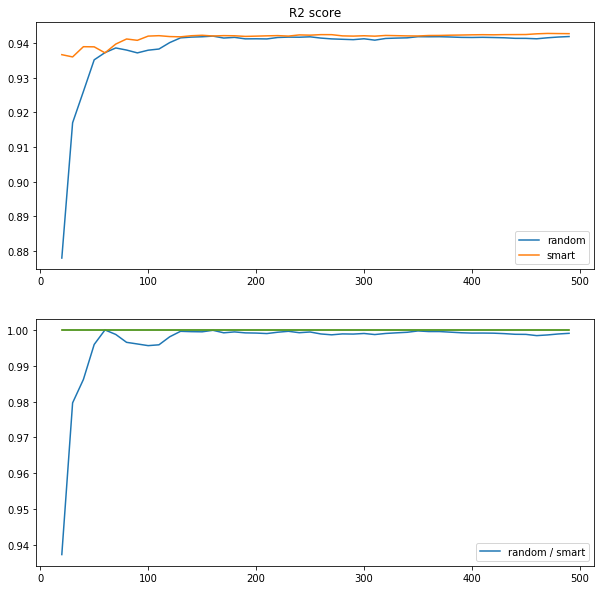

In [142]:
smart_agent = Agent('stat_volume')
random_agent = Agent('random')

agents = {'random': random_agent,
            'smart': smart_agent,
         }

scores = pd.DataFrame()
for i in range(500):
    ind = np.random.randint(S.shape[0], size=4)
    for agent_name, agent in agents.items():
#         print(i, agent_name)
        phi, r = agent.choose_phi(S[ind], R[ind])
        if i > 10 and i%10 == 0:
            agent.fit()
            r2, mse = agent.evaluate(S_test, R_test)
            scores.at[i, agent_name] = r2
scores
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
for agent_name in agents:
    ax[0].plot(scores[agent_name], label=agent_name)
ax[0].set_title('R2 score')
ax[0].legend()

ax[1].plot(scores['random'] / scores['smart'], label = 'random / smart')    
ax[1].plot(scores*0 + 1)   
# ax[0].title('R2 score')
ax[1].legend()
plt.show()

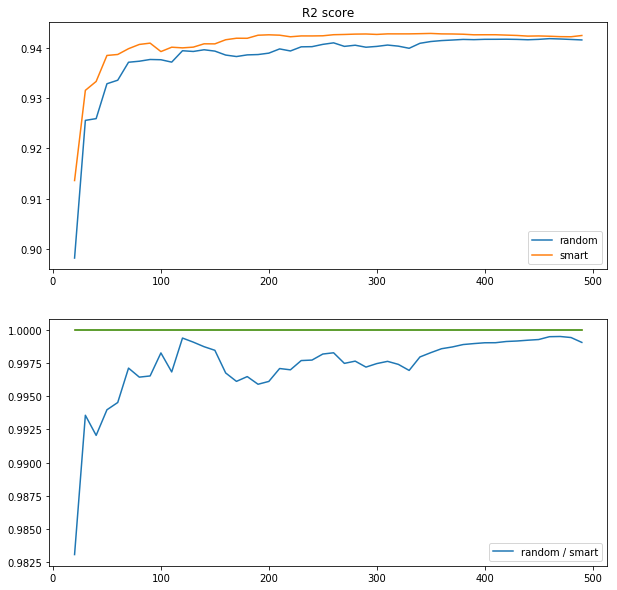

In [143]:
smart_agent = Agent('stat_volume')
random_agent = Agent('random')

agents = {'random': random_agent,
            'smart': smart_agent,
         }

scores = pd.DataFrame()
for i in range(500):
    ind = np.random.randint(S.shape[0], size=4)
    for agent_name, agent in agents.items():
#         print(i, agent_name)
        phi, r = agent.choose_phi(S[ind], R[ind])
        if i > 10 and i%10 == 0:
            agent.fit()
            r2, mse = agent.evaluate(S_test, R_test)
            scores.at[i, agent_name] = r2
scores
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
for agent_name in agents:
    ax[0].plot(scores[agent_name], label=agent_name)
ax[0].set_title('R2 score')
ax[0].legend()

ax[1].plot(scores['random'] / scores['smart'], label = 'random / smart')    
ax[1].plot(scores*0 + 1)   
# ax[0].title('R2 score')
ax[1].legend()
plt.show()

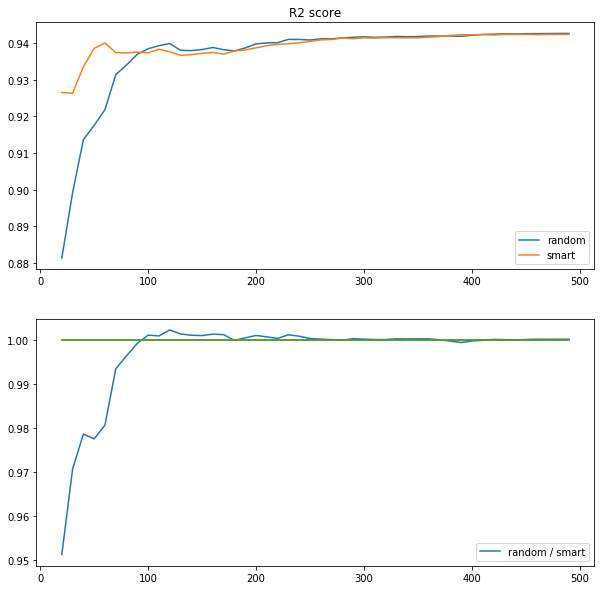

In [144]:
smart_agent = Agent('stat_volume')
random_agent = Agent('random')

agents = {'random': random_agent,
            'smart': smart_agent,
         }

scores = pd.DataFrame()
for i in range(500):
    ind = np.random.randint(S.shape[0], size=4)
    for agent_name, agent in agents.items():
#         print(i, agent_name)
        phi, r = agent.choose_phi(S[ind], R[ind])
        if i > 10 and i%10 == 0:
            agent.fit()
            r2, mse = agent.evaluate(S_test, R_test)
            scores.at[i, agent_name] = r2
scores
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
for agent_name in agents:
    ax[0].plot(scores[agent_name], label=agent_name)
ax[0].set_title('R2 score')
ax[0].legend()

ax[1].plot(scores['random'] / scores['smart'], label = 'random / smart')    
ax[1].plot(scores*0 + 1)   
# ax[0].title('R2 score')
ax[1].legend()
plt.show()

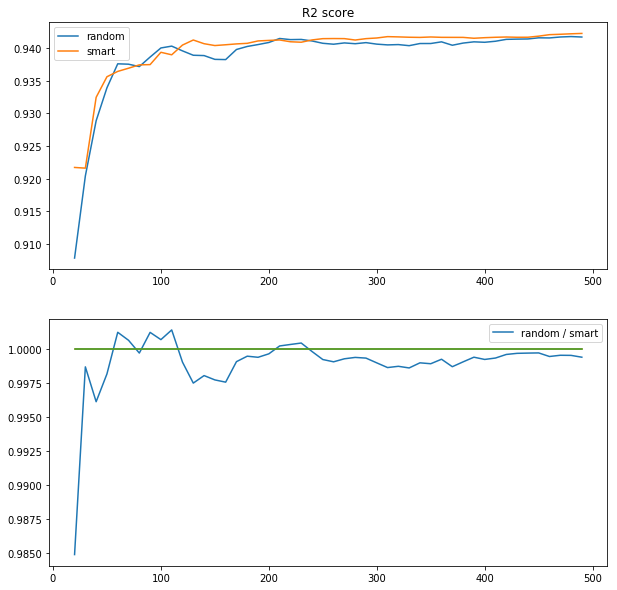

In [145]:
smart_agent = Agent('stat_volume')
random_agent = Agent('random')

agents = {'random': random_agent,
            'smart': smart_agent,
         }

scores = pd.DataFrame()
for i in range(500):
    ind = np.random.randint(S.shape[0], size=4)
    for agent_name, agent in agents.items():
#         print(i, agent_name)
        phi, r = agent.choose_phi(S[ind], R[ind])
        if i > 10 and i%10 == 0:
            agent.fit()
            r2, mse = agent.evaluate(S_test, R_test)
            scores.at[i, agent_name] = r2
scores
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
for agent_name in agents:
    ax[0].plot(scores[agent_name], label=agent_name)
ax[0].set_title('R2 score')
ax[0].legend()

ax[1].plot(scores['random'] / scores['smart'], label = 'random / smart')    
ax[1].plot(scores*0 + 1)   
# ax[0].title('R2 score')
ax[1].legend()
plt.show()

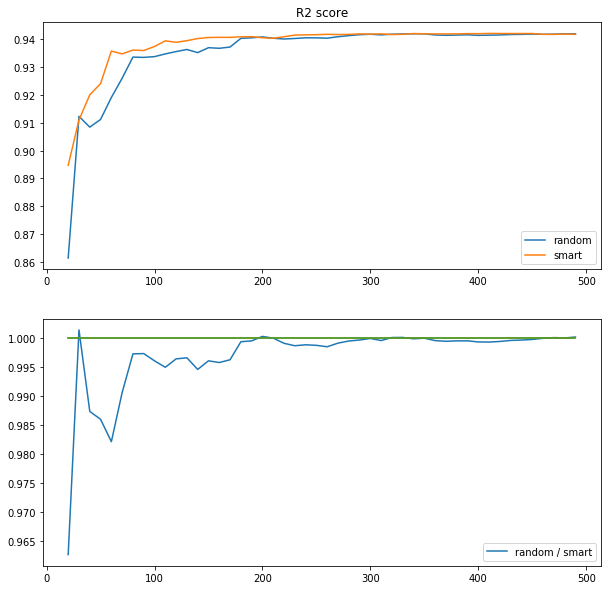

In [146]:
smart_agent = Agent('stat_volume')
random_agent = Agent('random')

agents = {'random': random_agent,
            'smart': smart_agent,
         }

scores = pd.DataFrame()
for i in range(500):
    ind = np.random.randint(S.shape[0], size=4)
    for agent_name, agent in agents.items():
#         print(i, agent_name)
        phi, r = agent.choose_phi(S[ind], R[ind])
        if i > 10 and i%10 == 0:
            agent.fit()
            r2, mse = agent.evaluate(S_test, R_test)
            scores.at[i, agent_name] = r2
scores
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
for agent_name in agents:
    ax[0].plot(scores[agent_name], label=agent_name)
ax[0].set_title('R2 score')
ax[0].legend()

ax[1].plot(scores['random'] / scores['smart'], label = 'random / smart')    
ax[1].plot(scores*0 + 1)   
# ax[0].title('R2 score')
ax[1].legend()
plt.show()

In [138]:
scores['random']

20     0.925475
30     0.929184
40     0.933036
50     0.932665
60     0.932887
70     0.935962
80     0.938090
90     0.938816
100    0.937118
110    0.938100
120    0.937529
130    0.936426
140    0.936914
150    0.937321
160    0.937135
170    0.937989
180    0.938753
190    0.939007
200    0.939067
210    0.939499
220    0.939133
230    0.939401
240    0.939889
250    0.939897
260    0.939809
270    0.940454
280    0.940681
290    0.940898
300    0.940716
310    0.941026
320    0.940803
330    0.940749
340    0.940482
350    0.940704
360    0.940634
370    0.940777
380    0.941093
390    0.941203
400    0.941274
410    0.941377
420    0.941507
430    0.941442
440    0.941458
450    0.941324
460    0.941381
470    0.941647
480    0.941650
490    0.941624
Name: random, dtype: float64

In [139]:
smart_agent.w

array([array([89.17498009]), array([6.48375202]), array([52.8494176]),
       array([22.95418174]), array([57.33112902]), array([82.86345736]),
       array([36.12277948]), array([53.5111135]), array([97.44103065]),
       array([70.81494509])], dtype=object)

In [98]:
scores

,smart,random
0,0.073787,0.009010
1,0.103978,0.263832
2,0.675810,0.341641
3,0.548269,0.404120
4,0.457308,0.401996
5,0.323538,0.473877
6,-0.688576,0.573388
7,-12.580280,0.637192
8,-26.154818,0.755548
9,-89.147737,0.737222
